In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import pandas as pd
import pyfftw
import re

import bacco
import baccoemu

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import utils
import plotter
import data_creation_pipeline as dcp
import compute_biased_pks_fields as cpk

%load_ext autoreload
%autoreload 2

2024-07-26 12:00:24.685004: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-26 12:00:26.858817: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-26 12:00:26.864480: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-26 12:00:51.092574: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-07-26 12:01:29.418281: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gp

In [43]:
n_grid = 128
n_grid_hr = 512
box_size = 1000.

In [85]:
k_min = 0.01
k_max = 0.68
n_bins = 60
log_binning = True
n_threads = 4

deposit_method = 'cic'
interlacing = False
correct_grid = True
deconvolve_grid = True
normalise_grid = False

# defaults from bacco.statistics.compute_power
# unless passed or otherwise denoted
args_power = {
    #"ngrid": n_grid,
    "box": box_size,
    #"pos": None,
    "vel": None,
    "mass": None,
    "interlacing": interlacing, #default: None
    "unit_in_Mpc": 1,
    "deposit_method": deposit_method, # default: 'cic',
    "bs_method": None,
    "bs_num_triangles": 10000,
    "bs_k1": 0.01,
    "bs_k2": None,
    "bs_deltak": None,
    "log_binning": log_binning,
    "kmin": k_min,
    "kmax": k_max,
    "nbins": n_bins,
    "correct_grid": correct_grid, #default: True,
    "deconvolve_grid": deconvolve_grid, #default: True,
    "normalise_grid": normalise_grid, #default: True,
    "totalmass": None,
    "correct_shotnoise": False,
    "zspace": False,
    #"cosmology": cosmo,
    "pmulti_interp": "polyfit",
    "nthreads": n_threads,
    "grid1": None,
    "dilution": None,
    "folds": None,
    "compute_correlation": False, #default: True
    "compute_power2d": False, #default: True
    "jack_error": False,
    "n_jack": None
}

# defaults from bacco.statistics.compute_crossspectrum_twogrids
# unless passed or otherwise denoted
args_power_grid = {
    # "grid1": None,
    # "grid2": None,
    "normalise_grid1": normalise_grid, #default: False
    "normalise_grid2": normalise_grid, #default: False
    "deconvolve_grid1": deconvolve_grid, #default: False
    "deconvolve_grid2": deconvolve_grid, #default: False
    "box": box_size,
    "mass1": None,
    "mass2": None,
    "interlacing": interlacing, #default: True
    "deposit_method": deposit_method, #default: "tsc",
    "log_binning": log_binning,
    "pk_lt": None,
    "kmin": k_min,
    "kmax": k_max,
    "nbins": n_bins,
    "correct_grid": correct_grid,
    "zspace": False,
    #"cosmology": cosmo,
    "pmulti_interp": "polyfit",
    "nthreads": n_threads,
    "compute_correlation": False, #default: True
    "compute_power2d": False, #default: True
    "folds": 1,
    "totalmass1": None,
    "totalmass2": None,
    "jack_error": False,
    "n_jack": None
}

pknbody_dict = {
    'min_k': k_min,
    'log_binning': log_binning,
    'log_binning_kmax': k_max,
    'log_binning_nbins': n_bins,
    'interlacing': interlacing,
    'depmethod': deposit_method,
    'correct_grid': correct_grid,
    'folds': 1 #default
}
bacco.configuration.update({'number_of_threads': n_threads})
bacco.configuration.update({'pknbody': pknbody_dict})
bacco.configuration.update({'pk' : {'maxk' : k_max}})
#bacco.configuration.update({'scaling' : {'disp_ngrid' : n_grid}})

args_power_grid_deconvolveFalse = args_power_grid.copy()
args_power_grid_deconvolveFalse['deconvolve_grid1'] = False
args_power_grid_deconvolveFalse['deconvolve_grid2'] = False


In [5]:
emu, emu_bounds, emu_param_names = utils.load_emu()
emu_bounds_dict = dict(zip(emu_param_names, emu_bounds))

Loading l-bias lpt emulator...


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 whe

L-bias lpt emulator loaded in memory.
Loading smeared bao emulator...


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Smeared bao emulator loaded in memory.
Loading non-linear l-bias emulator...


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.1.1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.1.1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Nonlinear l-bias emulator loaded in memory.
HIIII


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


# Muchisimocks

In [114]:
tag_params = '_p3_n500'
tag_mocks = f'{tag_params}_fixdamp'
#tag_mocks = f'{tag_params}'
dir_mocks = f'/cosmos_storage/cosmosims/muchisimocks_lib{tag_mocks}'

idxs_LH = np.arange(500)
n = len(idxs_LH)
print(n)

fn_params = f'{dir_mocks}/params_lh{tag_params}.txt'
fn_params_fixed = f'{dir_mocks}/params_fixed{tag_params}.txt'
params_df = pd.read_csv(fn_params, index_col=0)
param_dict_fixed = pd.read_csv(fn_params_fixed).loc[0].to_dict()


500


In [115]:
idx_LH = idxs_LH[1]
param_dict = params_df.loc[idx_LH].to_dict()
param_dict.update(param_dict_fixed)
print(param_dict)
cosmo = utils.get_cosmo(param_dict)

{'omega_cold': 0.369442113686239, 'sigma8_cold': 0.7796518702703259, 'hubble': 0.6930690180584014, 'omega_baryon': 0.049, 'ns': 0.9624, 'neutrino_mass': 0.0, 'w0': -1.0, 'wa': 0.0}
Param tau not in param dict, adding quijote value


### Muchisimocks PNN

In [117]:
tag_fields = '_deconvolved'
fn_fields = f'{dir_mocks}/LH{idx_LH}/bias_fields_eul{tag_fields}_{idx_LH}.npy'
bias_terms_eul = np.load(fn_fields)
print(bias_terms_eul.shape)

tag_fields = '_hr'
fn_fields = f'{dir_mocks}/LH{idx_LH}/bias_fields_eul{tag_fields}_{idx_LH}.npy'
bias_terms_eul_hr_nodeconv = np.load(fn_fields)
print(bias_terms_eul_hr_nodeconv.shape)

# tracer_field = utils.get_tracer_field(bias_terms_eul, bias_params, n_grid_norm=n_grid_hr)
# tracer_field_hr_nodeconv = utils.get_tracer_field(bias_terms_eul_hr_nodeconv, bias_params, n_grid_norm=n_grid_hr)

(5, 128, 128, 128)
(5, 512, 512, 512)


In [ ]:
# bias_terms_eul_hr = dcp.deconvolve_bias_field(bias_terms_eul_hr_nodeconv, n_grid_hr)
# # for some reason this pb function turns our float32 array into float64, 
# # convert back before saving
# bias_terms_eul_hr = bias_terms_eul_hr.astype(np.float32)

In [118]:
# from marcos's notebook:
#This is what I was talking about some corrections one can make to the P(k) computation
#Not very important though, ask Raul if you want to know more
lt_k = np.logspace(np.log10(np.pi / box_size), np.log10(2 * np.pi / box_size * n_grid_hr), num=90)
pk_lpt = bacco.utils.compute_pt_15_basis_terms(cosmo, expfactor=cosmo.expfactor, wavemode=lt_k)


In [119]:

#Compute a dummy variable with the 15 combinations of 5 distinct objects
import itertools
prod = np.array(list(itertools.combinations_with_replacement(np.arange(5),r=2)))

In [120]:
args_power_grid['normalise_grid1'], args_power_grid['deconvolve_grid1']

(False, True)

In [121]:
#Normalise the grid before P(k) computation
norm=n_grid_hr**3.
bias_terms_eul_hr_norm = bias_terms_eul_hr_nodeconv/norm

#Compute the P(k) of the 15 terms
power_all_terms = []
for ii in range(0,len(prod)):
    pk_lt = {'k':lt_k, 'pk':pk_lpt[0][ii], 'pk_nlin':pk_lpt[0][ii], 'pk_lt_log': True}
    if ii in [2,3,4,7,8,11,13]:
        pk_lt['pk_lt_log'] = False
    args_power['correct_grid'] = False if ii == 11 else True
    print(ii, prod[ii])
    power_term = bacco.statistics.compute_crossspectrum_twogrids(
                                                    grid1=bias_terms_eul_hr_norm[prod[ii,0]],
                                                    grid2=bias_terms_eul_hr_norm[prod[ii,1]],
                                                    cosmology=cosmo,
                                                    ngrid=n_grid_hr,
                                                    #normalise_grid1=False,
                                                    #normalise_grid2=False,
                                                    **args_power_grid
                                                    #**args_power_grid_deconvolveFalse
                                                    )
    power_all_terms.append(power_term)


2024-07-26 16:20:46,212 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


0 [0 0]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 2.462369 sec
bacco.power : Counting modes
bacco.power : done counting modes in 1.382254 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000431 secs
bacco.power : Deallocating arrays


2024-07-26 16:20:52,092 bacco.statistics :  ...done in 5.88 s
2024-07-26 16:20:52,093 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


1 [0 1]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1.67776e-10 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 3.314891 sec
bacco.power : Counting modes
bacco.power : done counting modes in 2.176820 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000604 secs
bacco.power : Deallocating arrays


2024-07-26 16:20:59,116 bacco.statistics :  ...done in 7.02 s
2024-07-26 16:20:59,118 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


2 [0 2]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 3.79164e-07 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 3.893240 sec
bacco.power : Counting modes
bacco.power : done counting modes in 1.617441 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000523 secs
bacco.power : Deallocating arrays


2024-07-26 16:21:06,697 bacco.statistics :  ...done in 7.58 s
2024-07-26 16:21:06,700 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


3 [0 3]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 5.95627e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 3.175955 sec
bacco.power : Counting modes
bacco.power : done counting modes in 1.235143 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000581 secs
bacco.power : Deallocating arrays


2024-07-26 16:21:14,326 bacco.statistics :  ...done in 7.63 s
2024-07-26 16:21:14,327 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


4 [0 4]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1.01292e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 2.615549 sec
bacco.power : Counting modes
bacco.power : done counting modes in 1.156395 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000664 secs
bacco.power : Deallocating arrays


2024-07-26 16:21:22,113 bacco.statistics :  ...done in 7.79 s
2024-07-26 16:21:22,115 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


5 [1 1]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1.67776e-10 (grid1) 1.67776e-10 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 3.087386 sec
bacco.power : Counting modes
bacco.power : done counting modes in 1.625677 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000525 secs
bacco.power : Deallocating arrays


2024-07-26 16:21:29,922 bacco.statistics :  ...done in 7.81 s
2024-07-26 16:21:29,924 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


6 [1 2]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1.67776e-10 (grid1) 3.79164e-07 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 2.211653 sec
bacco.power : Counting modes
bacco.power : done counting modes in 1.404703 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000445 secs
bacco.power : Deallocating arrays


2024-07-26 16:21:37,348 bacco.statistics :  ...done in 7.42 s
2024-07-26 16:21:37,350 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


7 [1 3]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1.67776e-10 (grid1) 5.95627e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 3.731360 sec
bacco.power : Counting modes
bacco.power : done counting modes in 2.704493 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000700 secs
bacco.power : Deallocating arrays


2024-07-26 16:21:46,624 bacco.statistics :  ...done in 9.27 s
2024-07-26 16:21:46,627 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


8 [1 4]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1.67776e-10 (grid1) 1.01292e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 2.354001 sec
bacco.power : Counting modes
bacco.power : done counting modes in 1.522503 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000676 secs
bacco.power : Deallocating arrays


2024-07-26 16:21:52,595 bacco.statistics :  ...done in 5.97 s
2024-07-26 16:21:52,596 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


9 [2 2]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 3.79164e-07 (grid1) 3.79164e-07 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 2.585913 sec
bacco.power : Counting modes
bacco.power : done counting modes in 1.215730 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000697 secs
bacco.power : Deallocating arrays


2024-07-26 16:21:59,946 bacco.statistics :  ...done in 7.35 s
2024-07-26 16:21:59,947 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


10 [2 3]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 3.79164e-07 (grid1) 5.95627e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 2.302111 sec
bacco.power : Counting modes
bacco.power : done counting modes in 1.434554 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000691 secs
bacco.power : Deallocating arrays


2024-07-26 16:22:06,250 bacco.statistics :  ...done in 6.3 s
2024-07-26 16:22:06,252 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


11 [2 4]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 3.79164e-07 (grid1) 1.01292e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 2.806232 sec
bacco.power : Counting modes
bacco.power : done counting modes in 1.269645 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000523 secs
bacco.power : Deallocating arrays


2024-07-26 16:22:13,388 bacco.statistics :  ...done in 7.14 s
2024-07-26 16:22:13,390 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


12 [3 3]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 5.95627e-06 (grid1) 5.95627e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 2.482154 sec
bacco.power : Counting modes
bacco.power : done counting modes in 1.312862 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000323 secs
bacco.power : Deallocating arrays


2024-07-26 16:22:18,715 bacco.statistics :  ...done in 5.33 s
2024-07-26 16:22:18,716 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


13 [3 4]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 5.95627e-06 (grid1) 1.01292e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 2.082312 sec
bacco.power : Counting modes
bacco.power : done counting modes in 1.438102 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000418 secs
bacco.power : Deallocating arrays


2024-07-26 16:22:24,222 bacco.statistics :  ...done in 5.51 s
2024-07-26 16:22:24,223 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


14 [4 4]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1.01292e-11 (grid1) 1.01292e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 2.050259 sec
bacco.power : Counting modes
bacco.power : done counting modes in 1.433603 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000639 secs
bacco.power : Deallocating arrays


2024-07-26 16:22:29,778 bacco.statistics :  ...done in 5.55 s


### Emu PNN

In [122]:
kk = power_all_terms[0]['k']
i_k_emu = kk<0.75
kk_emu = kk[i_k_emu]
cosmo_params_emu = utils.cosmo_bacco_to_cosmo_baccoemu(cosmo)
_, pnn_emu_mm = emu.get_nonlinear_pnn(k=kk_emu, **cosmo_params_emu)

### Plot

12


/tmp/ipykernel_378322/2667204812.py:23: RuntimeWarning: divide by zero encountered in divide
  ax_err[contf].semilogx(kk_emu, (pnn_emu[ii]-pk_pred[i_k_emu])/pk_pred[i_k_emu],


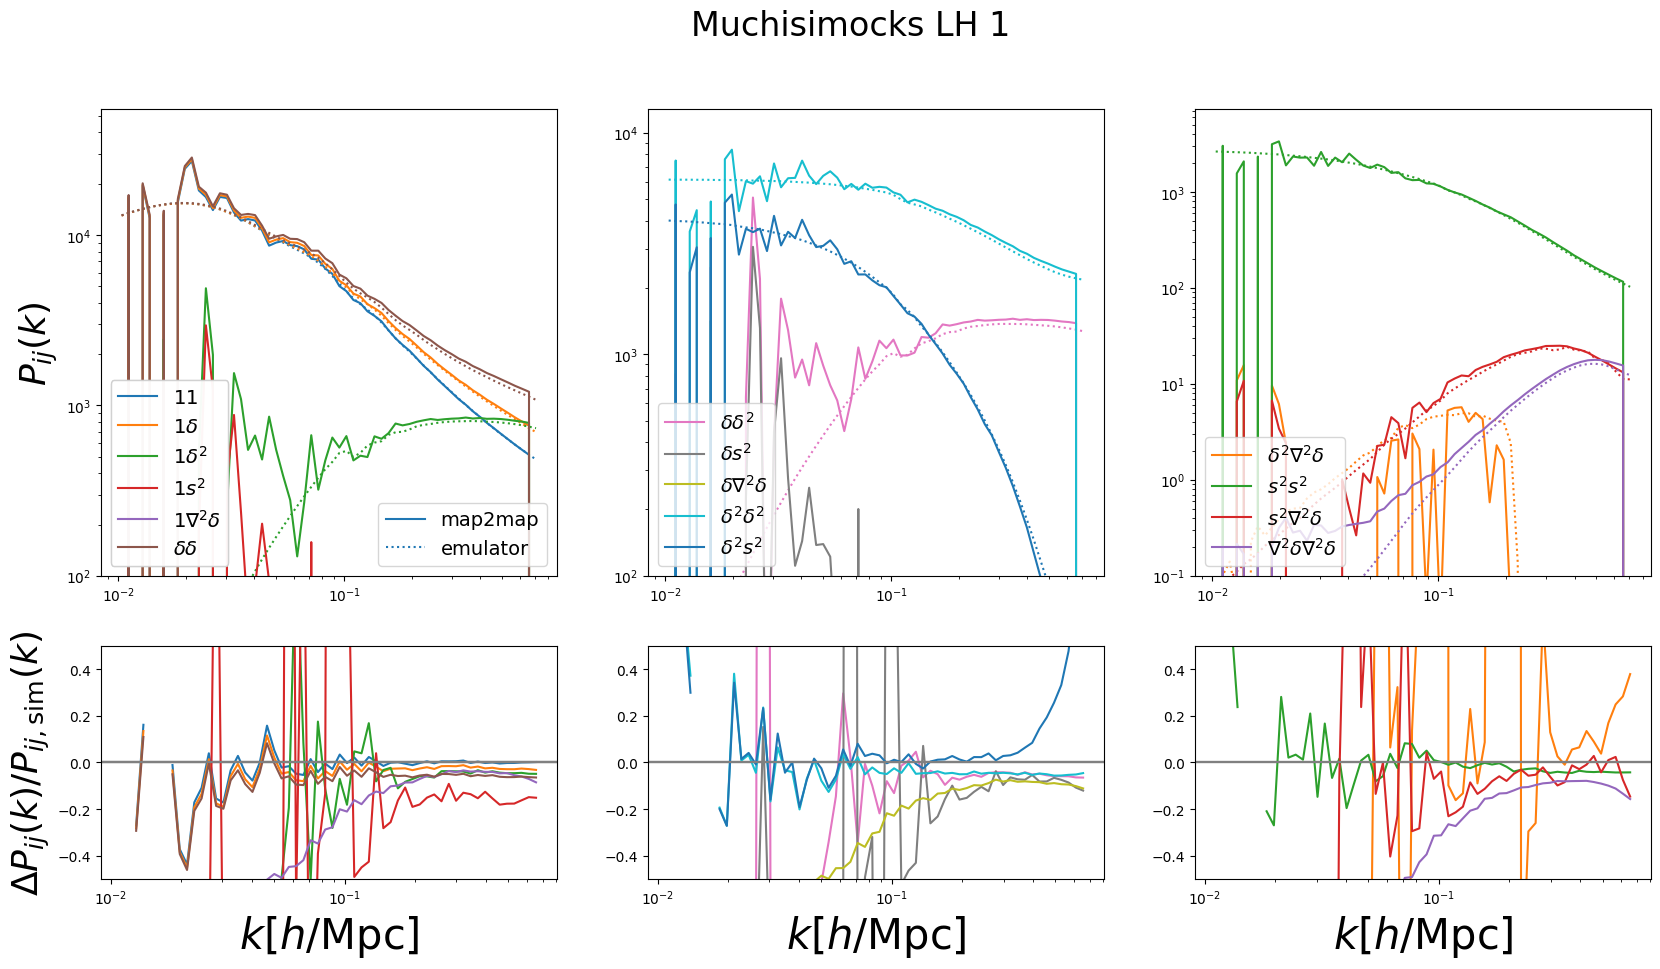

In [131]:
fig, axarr = plt.subplots(2, 3, figsize=(20,10), height_ratios=[2,1])
ax, ax_err = axarr

pnn_emu = pnn_emu_mm
labels_pnn = utils.labels_pnn

plt.suptitle(f'Muchisimocks LH {idx_LH}',
                 fontsize=24)

contf=0
for ii in range(len(power_all_terms)):
    #mask = np.abs(power_all_terms_sim[ii]['pk'])>0
    # pk_sim = power_all_terms_sim[ii]['pk'][mask]
    # pk_pred = power_all_terms_pred[ii]['pk'][mask]
    
    pk_pred = power_all_terms[ii]['pk']

    ax[contf].loglog(kk, pk_pred,
                       color='C'+str(ii), label=labels_pnn[ii])
    ax[contf].loglog(kk_emu, pnn_emu[ii], ls=':', color='C'+str(ii), 
                     )
    
    ax_err[contf].semilogx(kk_emu, (pnn_emu[ii]-pk_pred[i_k_emu])/pk_pred[i_k_emu], 
                         ls='-', color='C'+str(ii),)
    
    ax[contf].legend(loc='lower left', frameon=True, fancybox=True, fontsize=14)
    
    ax_err[contf].set_xlabel(r'$k[h/$Mpc]', size=30)
    ax_err[contf].axhline(0, ls='-', color='grey')
    ax_err[contf].set_ylim(-0.5, 0.5)
    
    if ii%5==0 and ii>0:
        contf+=1

ax[0].set_ylabel(r'$P_{ij}(k)$', size=26)
ax_err[0].set_ylabel(r'$\Delta P_{ij}(k) / P_{ij,\text{sim}}(k)$', size=26)
ax[0].set_ylim(1e2)
ax[1].set_ylim(1e2)
ax[2].set_ylim(1e-1)

# where some data has already been plotted to ax
handles, labels = ax[0].get_legend_handles_labels()
lines = ax[0].get_lines()
print(len(lines))
legend = ax[0].legend([lines[i] for i in [0,1]], ["map2map", "emulator"], loc='lower right',
                      frameon=True, fancybox=True, fontsize=14)
ax[0].add_artist(legend)

legend_orig = ax[0].legend(handles, labels, loc='lower left',
                           frameon=True, fancybox=True, fontsize=14)
ax[0].add_artist(legend_orig)
# from matplotlib.lines import Line2D
# handles, labels = ax[0].get_legend_handles_labels()
# line_emu = Line2D([0], [0], ls=':', color='C'+str(0), label='emulator')
# line_pred = Line2D([0], [0], ls='-', color='C'+str(0), label='pred (map2map)')
# line_sim = Line2D([0], [0], marker='o', color='C'+str(0), label='sim')
# handles.extend([line_emu, line_pred, line_sim]) 
# ax[0].legend(handles=handles, loc='lower left', frameon=True, fancybox=True, fontsize=14)


# if save_plots:
#     print(f'Saving {plot_dir}/quijote_LH{indicesLH[i]}_pnn{tag_save}.png')
#     plt.savefig(f'{plot_dir}/quijote_LH{indicesLH[i]}_pnn{tag_save}.png', bbox_inches='tight')

/tmp/ipykernel_378322/2406439420.py:28: RuntimeWarning: divide by zero encountered in divide
  axarr[1].plot(kk_emu, (pnn_emu[i_pnn]-pk_obj['pk'][i_k_emu])/pk_obj['pk'][i_k_emu], ls='-', alpha=alpha, color=color, lw=lw)


10


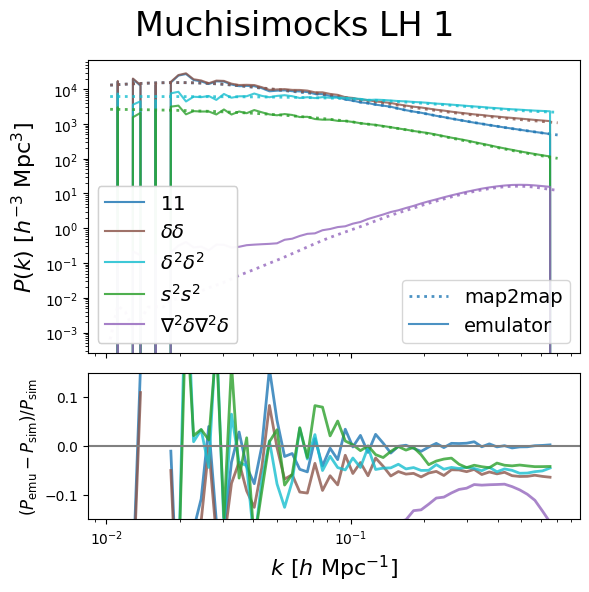

In [130]:
nrows, ncols = 2, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,6), sharex=True, height_ratios=[2,1])
plt.subplots_adjust(hspace=0.01, wspace=0.01)
ax, ax1 = axarr
alpha = 0.8

pnn_emu = pnn_emu_mm

plt.suptitle(f'Muchisimocks LH {idx_LH}',
                 fontsize=24)

color_pdd = 'C'+str(5)

#k = kk
lw = 2

#is_pnn = [0,5]
is_pnn = [i for i in range(len(prod)) if prod[i][0]==prod[i][1]]
for i_pnn in is_pnn:
    pk_obj = power_all_terms[i_pnn]
    color = 'C'+str(i_pnn)
    axarr[0].plot(kk_emu, pnn_emu[i_pnn], ls=':', alpha=alpha, 
                  #label=f'{labels_pnn[i_pnn]}, emu', 
                  color=color, lw=lw)
    axarr[0].plot(kk, pk_obj['pk'], ls='-', markersize=3, alpha=alpha, color=color,
                  label=f'{labels_pnn[i_pnn]}'
                  )
    axarr[1].plot(kk_emu, (pnn_emu[i_pnn]-pk_obj['pk'][i_k_emu])/pk_obj['pk'][i_k_emu], ls='-', alpha=alpha, color=color, lw=lw)

ax1.axhline(0.0, color='grey')

axarr[-1].set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)
axarr[1].set_ylabel(r'$(P_\text{emu}-P_\text{sim})/P_\text{sim}$', fontsize=12)
#ax.set_xlim(k_min, k_max)
#ax.set_ylim(3e2, 5e4)
#ax.set_ylim(1e3, 5e5)

ax1.set_ylim(-0.15, 0.15)

ax.legend(fontsize=12, loc='lower left')

handles, labels = ax.get_legend_handles_labels()
lines = ax.get_lines()
print(len(lines))
legend = ax.legend([lines[i] for i in [0,1]], ["map2map", "emulator"], loc='lower right',
                      frameon=True, fancybox=True, fontsize=14)
ax.add_artist(legend)

legend_orig = ax.legend(handles, labels, loc='lower left',
                           frameon=True, fancybox=True, fontsize=14)
ax.add_artist(legend_orig)

ax.set_xscale('log')
ax.set_yscale('log')

mpl.pyplot.tight_layout()
# mpl.pyplot.show()

# if save_plots:
#     print(f'Saving {plot_dir}/quijote_LH{indicesLH[i]}_pnnzooom{tag_save}.png')
#     plt.savefig(f'{plot_dir}/quijote_LH{indicesLH[i]}_pnnzooom{tag_save}.png', bbox_inches='tight')

/tmp/ipykernel_378322/1348183550.py:31: RuntimeWarning: invalid value encountered in divide
  axarr[1].plot(kk_emu, (pk_obj['pk']-pk_obj_compare['pk'])/pk_obj_compare['pk'], ls='-', alpha=alpha, color=color, lw=lw)


6


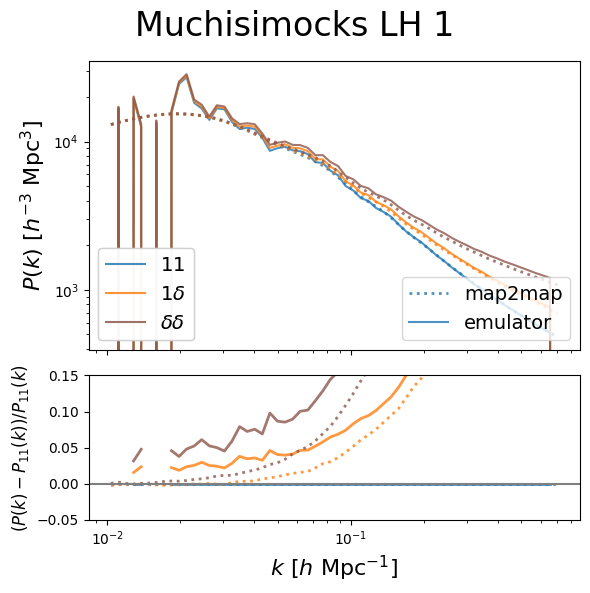

In [159]:
nrows, ncols = 2, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,6), sharex=True, height_ratios=[2,1])
plt.subplots_adjust(hspace=0.01, wspace=0.01)
ax, ax1 = axarr
alpha = 0.8

pnn_emu = pnn_emu_mm

plt.suptitle(f'Muchisimocks LH {idx_LH}',
                 fontsize=24)

color_pdd = 'C'+str(5)

#k = kk
lw = 2

i_compare = 0
is_pnn = [0,1,5]
#is_pnn = [i for i in range(len(prod)) if prod[i][0]==prod[i][1]]
pk_obj_compare = power_all_terms[i_compare]
for i_pnn in is_pnn:
    pk_obj = power_all_terms[i_pnn]
    color = 'C'+str(i_pnn)
    axarr[0].plot(kk_emu, pnn_emu[i_pnn], ls=':', alpha=alpha, 
                  #label=f'{labels_pnn[i_pnn]}, emu', 
                  color=color, lw=lw)
    axarr[0].plot(kk, pk_obj['pk'], ls='-', markersize=3, alpha=alpha, color=color,
                  label=f'{labels_pnn[i_pnn]}'
                  )
    axarr[1].plot(kk_emu, (pnn_emu[i_pnn]-pnn_emu[i_compare])/pnn_emu[i_compare], ls=':', alpha=alpha, color=color, lw=lw)
    axarr[1].plot(kk_emu, (pk_obj['pk']-pk_obj_compare['pk'])/pk_obj_compare['pk'], ls='-', alpha=alpha, color=color, lw=lw)

ax1.axhline(0.0, color='grey')

axarr[-1].set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)
#axarr[1].set_ylabel(rf'$(P(k)-P_{{{labels_pnn[i_compare]}}}(k))/P_{{{labels_pnn[i_compare]}}}(k)$', fontsize=12)
axarr[1].set_ylabel(r'$(P(k)-P_\text{11}(k))/P_\text{11}(k)$', fontsize=12)
#ax.set_xlim(k_min, k_max)
#ax.set_ylim(3e2, 5e4)
#ax.set_ylim(1e3, 5e5)

ax1.set_ylim(-0.05, 0.15)

ax.legend(fontsize=12, loc='lower left')

handles, labels = ax.get_legend_handles_labels()
lines = ax.get_lines()
print(len(lines))
legend = ax.legend([lines[i] for i in [0,1]], ["map2map", "emulator"], loc='lower right',
                      frameon=True, fancybox=True, fontsize=14)
ax.add_artist(legend)

legend_orig = ax.legend(handles, labels, loc='lower left',
                           frameon=True, fancybox=True, fontsize=14)
ax.add_artist(legend_orig)

ax.set_xscale('log')
ax.set_yscale('log')

mpl.pyplot.tight_layout()
# mpl.pyplot.show()

# if save_plots:
#     print(f'Saving {plot_dir}/quijote_LH{indicesLH[i]}_pnnzooom{tag_save}.png')
#     plt.savefig(f'{plot_dir}/quijote_LH{indicesLH[i]}_pnnzooom{tag_save}.png', bbox_inches='tight')

In [154]:
is_k=np.arange(5)
for i_pnn in is_pnn:
    print(pnn_emu_mm[i_pnn][is_k])
for i_pnn in is_pnn:
    print(power_all_terms[i_pnn]['pk'][is_k])

[13035.19877309 13464.20739658 13864.42687884 14237.54898595
 14577.00858851]
[13043.73857212 13492.71879055 13871.0215457  14230.29674891
 14583.73822609]
[    0.         16493.82892863     0.         19507.39537996
 12550.91056876]
[    0.         17170.4358866      0.         20125.08290878
 13149.76531799]


### Quijote

In [132]:
idx_LH_str = '0663' # quijote LH idx to test
dir_data = '/cosmos_storage/home/mpelle/Yin_data/Quijote'
param_names = ['omega_m', 'omega_baryon', 'h', 'n_s', 'sigma_8']

In [133]:
fn_params_quijote = f'{dir_data}/LH{idx_LH_str}/param_{idx_LH_str}.txt'
param_vals_quijote = np.loadtxt(fn_params_quijote)
param_dict_quijote = dict(zip(param_names, param_vals_quijote))
cosmo_quijote = utils.get_cosmo(param_dict_quijote)
cosmo_params_emu_quijote = utils.cosmo_bacco_to_cosmo_baccoemu(cosmo_quijote)

Param tau not in param dict, adding quijote value
Param neutrino_mass not in param dict, adding quijote value
Param w0 not in param dict, adding quijote value
Param wa not in param dict, adding quijote value


In [134]:
tag_fields = '_interlacingfalse'
dir_fields = f'/cosmos_storage/home/kstoreyf/data_muchisimocks/quijote_LH{tag_fields}'

In [135]:
tag = '_sim'
fn_fields = f'{dir_fields}/LH{idx_LH_str}/Eulerian_fields{tag}_{idx_LH_str}.npy'
bias_terms_eul_sim = np.load(fn_fields, allow_pickle=True)


In [136]:
bias_terms_eul_sim_deconvolved = dcp.deconvolve_bias_field(bias_terms_eul_sim, n_grid_hr)
# for some reason this pb function turns our float32 array into float64, 
# convert back before saving
bias_terms_eul_sim_deconvolved = bias_terms_eul_sim_deconvolved.astype(np.float32)

In [137]:
bias_params = [0,0,0,0]
title_tag = ', b=[0,0,0,0]'

tracer_field_sim = utils.get_tracer_field(bias_terms_eul_sim, bias_params, n_grid_norm=n_grid_hr)

In [138]:
tracer_field_sim_deconvolved = utils.get_tracer_field(bias_terms_eul_sim_deconvolved, bias_params, n_grid_norm=n_grid_hr)

In [139]:
pk_obj_sim = bacco.statistics.compute_crossspectrum_twogrids(
                    grid1=tracer_field_sim,
                    grid2=tracer_field_sim,
                    cosmology=cosmo_quijote,
                    ngrid=n_grid_hr,
                    **args_power_grid)

2024-07-26 17:07:14,051 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 2.562130 sec
bacco.power : Counting modes
bacco.power : done counting modes in 1.150306 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000328 secs
bacco.power : Deallocating arrays


2024-07-26 17:07:24,725 bacco.statistics :  ...done in 10.7 s


In [140]:
bacco.configuration.update({'pknbody' : {'ngrid'  :  n_grid_hr}})
bacco.configuration.update({'scaling' : {'disp_ngrid' : n_grid_hr}})

In [141]:
args_power_grid['normalise_grid1'], args_power_grid_deconvolveFalse['normalise_grid1']

(False, False)

In [148]:
#Normalise the grid before P(k) computation
norm=n_grid_hr**3.

#Compute the P(k) of the 15 terms
power_all_terms_sim_quijote = []
for ii in range(0,len(prod)):
    pk_lt = {'k':lt_k, 'pk':pk_lpt[0][ii], 'pk_nlin':pk_lpt[0][ii], 'pk_lt_log': True}
    if ii in [2,3,4,7,8,11,13]:
        pk_lt['pk_lt_log'] = False
    args_power['correct_grid'] = False if ii == 11 else True
    print(ii, prod[ii])
    power_term = bacco.statistics.compute_crossspectrum_twogrids(
                                                    grid1=(bias_terms_eul_sim/norm)[prod[ii,0]],
                                                    grid2=(bias_terms_eul_sim/norm)[prod[ii,1]],
                                                    #grid1=(bias_terms_eul_sim_deconvolved)[prod[ii,0]],
                                                    #grid2=(bias_terms_eul_sim_deconvolved)[prod[ii,1]],
                                                    cosmology=cosmo_quijote,
                                                    ngrid=n_grid_hr,
                                                    #normalise_grid1=False,
                                                    #normalise_grid2=False,
                                                    #**args_power_grid_deconvolveFalse
                                                    **args_power_grid
                                                    )
    power_all_terms_sim_quijote.append(power_term)


0 [0 0]


2024-07-26 17:10:52,519 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.691985 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.994225 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000384 secs
bacco.power : Deallocating arrays


2024-07-26 17:10:58,562 bacco.statistics :  ...done in 6.04 s


1 [0 1]


2024-07-26 17:11:02,190 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) -5.39212e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.614686 sec
bacco.power : Counting modes
bacco.power : done counting modes in 1.157973 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000511 secs
bacco.power : Deallocating arrays


2024-07-26 17:11:07,659 bacco.statistics :  ...done in 5.47 s


2 [0 2]


2024-07-26 17:11:11,511 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 5.40513e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.441189 sec
bacco.power : Counting modes
bacco.power : done counting modes in 1.063613 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000391 secs
bacco.power : Deallocating arrays


2024-07-26 17:11:16,701 bacco.statistics :  ...done in 5.19 s


3 [0 3]


2024-07-26 17:11:20,269 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 9.97816e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.800883 sec
bacco.power : Counting modes
bacco.power : done counting modes in 1.025607 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000373 secs
bacco.power : Deallocating arrays


2024-07-26 17:11:25,880 bacco.statistics :  ...done in 5.61 s


4 [0 4]


2024-07-26 17:11:29,688 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) -2.06936e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 2.019226 sec
bacco.power : Counting modes
bacco.power : done counting modes in 1.084543 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000357 secs
bacco.power : Deallocating arrays


2024-07-26 17:11:35,654 bacco.statistics :  ...done in 5.97 s


5 [1 1]


2024-07-26 17:11:39,189 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -5.39212e-11 (grid1) -5.39212e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.853764 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.912955 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.003096 secs
bacco.power : Deallocating arrays


2024-07-26 17:11:44,783 bacco.statistics :  ...done in 5.59 s


6 [1 2]


2024-07-26 17:11:48,545 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -5.39212e-11 (grid1) 5.40513e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.652267 sec
bacco.power : Counting modes
bacco.power : done counting modes in 1.309590 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000463 secs
bacco.power : Deallocating arrays


2024-07-26 17:11:54,277 bacco.statistics :  ...done in 5.73 s


7 [1 3]


2024-07-26 17:11:59,039 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -5.39212e-11 (grid1) 9.97816e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.979165 sec
bacco.power : Counting modes
bacco.power : done counting modes in 1.216982 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000408 secs
bacco.power : Deallocating arrays


2024-07-26 17:12:04,991 bacco.statistics :  ...done in 5.95 s


8 [1 4]


2024-07-26 17:12:08,497 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -5.39212e-11 (grid1) -2.06936e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 2.870788 sec
bacco.power : Counting modes
bacco.power : done counting modes in 1.360172 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000415 secs
bacco.power : Deallocating arrays


2024-07-26 17:12:16,124 bacco.statistics :  ...done in 7.63 s


9 [2 2]


2024-07-26 17:12:19,903 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 5.40513e-06 (grid1) 5.40513e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 2.695450 sec
bacco.power : Counting modes
bacco.power : done counting modes in 1.646766 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000394 secs
bacco.power : Deallocating arrays


2024-07-26 17:12:28,093 bacco.statistics :  ...done in 8.19 s


10 [2 3]


2024-07-26 17:12:34,261 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 5.40513e-06 (grid1) 9.97816e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 2.932730 sec
bacco.power : Counting modes
bacco.power : done counting modes in 1.275729 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000610 secs
bacco.power : Deallocating arrays


2024-07-26 17:12:41,742 bacco.statistics :  ...done in 7.48 s


11 [2 4]


2024-07-26 17:12:46,321 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 5.40513e-06 (grid1) -2.06936e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 3.301729 sec
bacco.power : Counting modes
bacco.power : done counting modes in 1.882195 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000697 secs
bacco.power : Deallocating arrays


2024-07-26 17:12:54,726 bacco.statistics :  ...done in 8.4 s


12 [3 3]


2024-07-26 17:12:58,887 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 9.97816e-06 (grid1) 9.97816e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 2.010279 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.942087 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000328 secs
bacco.power : Deallocating arrays


2024-07-26 17:13:05,641 bacco.statistics :  ...done in 6.75 s


13 [3 4]


2024-07-26 17:13:09,169 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 9.97816e-06 (grid1) -2.06936e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 1.583112 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.990560 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000547 secs
bacco.power : Deallocating arrays


2024-07-26 17:13:14,433 bacco.statistics :  ...done in 5.26 s


14 [4 4]


2024-07-26 17:13:18,240 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 4; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -2.06936e-11 (grid1) -2.06936e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 2.072556 sec
bacco.power : Counting modes
bacco.power : done counting modes in 1.229895 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000563 secs
bacco.power : Deallocating arrays


2024-07-26 17:13:24,245 bacco.statistics :  ...done in 6.01 s


In [149]:
kk_quijote = pk_obj_sim['k']
_, pk_model_unscaled_quijote, _ = emu.get_galaxy_real_pk(bias=bias_params, k=kk, 
                                                   cold=True, **cosmo_params_emu_quijote)
pk_emu_quijote = pk_model_unscaled_quijote

In [150]:
kk = power_all_terms_sim_quijote[0]['k']
i_k_emu = kk<0.75
kk_emu = kk[i_k_emu]
_, pnn_emu_quijote = emu.get_nonlinear_pnn(k=kk_emu, **cosmo_params_emu_quijote)

/tmp/ipykernel_378322/479691453.py:23: RuntimeWarning: divide by zero encountered in divide
  axarr[1].plot(kk_emu, (pnn_emu[i_pnn]-pk_obj['pk'][i_k_emu])/pk_obj['pk'][i_k_emu], ls='-', alpha=alpha, color=color, lw=lw)


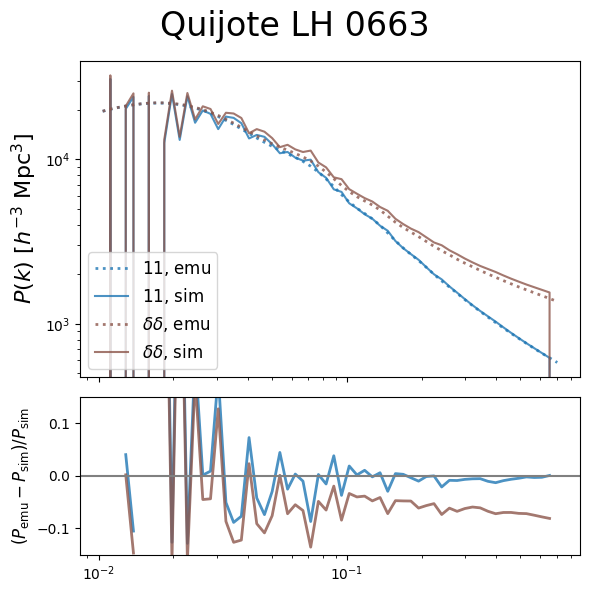

In [151]:
nrows, ncols = 2, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,6), sharex=True, height_ratios=[2,1])
plt.subplots_adjust(hspace=0.01, wspace=0.01)
ax, ax1 = axarr
alpha = 0.8

plt.suptitle(f'Quijote LH {idx_LH_str}',
                 fontsize=24)

color_pdd = 'C'+str(5)

#k = kk
lw = 2

pnn_emu = pnn_emu_quijote

is_pnn = [0,5]
for i_pnn in is_pnn:
    pk_obj = power_all_terms_sim_quijote[i_pnn]
    color = 'C'+str(i_pnn)
    axarr[0].plot(kk_emu, pnn_emu[i_pnn], ls=':', alpha=alpha, label=f'{labels_pnn[i_pnn]}, emu', color=color, lw=lw)
    axarr[0].plot(kk, pk_obj['pk'], ls='-', markersize=3, alpha=alpha, label=f'{labels_pnn[i_pnn]}, sim', color=color)
    axarr[1].plot(kk_emu, (pnn_emu[i_pnn]-pk_obj['pk'][i_k_emu])/pk_obj['pk'][i_k_emu], ls='-', alpha=alpha, color=color, lw=lw)

ax1.axhline(0.0, color='grey')

ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)
axarr[1].set_ylabel(r'$(P_\text{emu}-P_\text{sim})/P_\text{sim}$', fontsize=12)
#ax.set_xlim(k_min, k_max)
#ax.set_ylim(3e2, 5e4)
#ax.set_ylim(1e3, 5e5)

ax1.set_ylim(-0.15, 0.15)

ax.legend(fontsize=12, loc='lower left')

ax.set_xscale('log')
ax.set_yscale('log')

mpl.pyplot.tight_layout()
# mpl.pyplot.show()

# if save_plots:
#     print(f'Saving {plot_dir}/quijote_LH{indicesLH[i]}_pnnzooom{tag_save}.png')
#     plt.savefig(f'{plot_dir}/quijote_LH{indicesLH[i]}_pnnzooom{tag_save}.png', bbox_inches='tight')

/tmp/ipykernel_378322/887337405.py:49: RuntimeWarning: divide by zero encountered in divide
  ax1.plot(ks[i], (pk_emu-pks[i])/errs[i], ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
/tmp/ipykernel_378322/887337405.py:50: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(ks[i], (pk_emu/pks[i]), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])


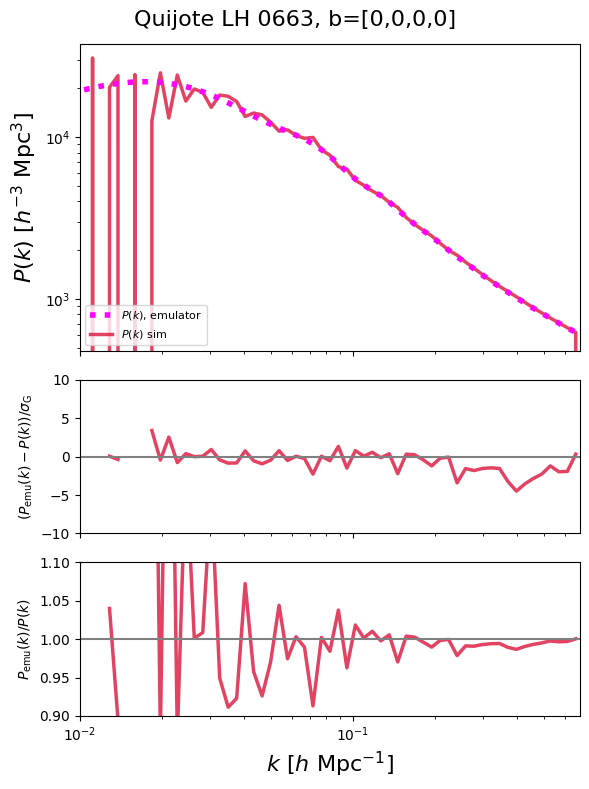

In [152]:
nrows, ncols = 3, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,8), sharex=True, height_ratios=[2,1,1])
plt.subplots_adjust(hspace=0.01, wspace=0.01)
ax, ax1, ax2 = axarr
alpha = 0.8

labels = [
          r'$P(k)$ sim',
          ]
colors = ['crimson', 'orange', #'purple', 
          'crimson', 'orange', #'purple', 
          'orange']
lss = ['-', '-',
       '--', '--']
lws = [2.5, 1.5,
       2.5, 1.5]
pk_objs = [pk_obj_sim,
           ]
pk_emu = pk_emu_quijote
#zorders = list(range(len(pk_objs),0,-1))
zorders = list(range(len(pk_objs)))
ks = [pk_obj['k'] for pk_obj in pk_objs]
pks = [pk_obj['pk'] for pk_obj in pk_objs]
errs = [pk_obj['pk_gaussian_error'] for pk_obj in pk_objs]

# ks.append(kk)
# pks.append(pk_nlz)
# errs.append(None)
# #errs.append(bacco.statistics.approx_pk_gaussian_error(k_quijote, pk_quijote, box_size))
# labels.append(r'$P(k)$ NLz')
# colors.append('grey')
# lss.append('-')
# lws.append(1)
# zorders.append(0)

plt.suptitle(f'Quijote LH {idx_LH_str}{title_tag}', fontsize=16)

ax.loglog(kk, pk_emu, label=r'$P(k)$, emulator', ls=':', color='magenta', lw=4)

for i in range(len(pks)):
    ax.loglog(ks[i], pks[i], ls=lss[i], label=labels[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
    if len(pk_emu)!=len(pks[i]):
        pk_interp = np.interp(kk, ks[i], pks[i])
        err_interp = np.interp(kk, ks[i], errs[i])
        ax1.plot(kk, (pk_emu-pk_interp)/err_interp, ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
        ax2.plot(kk, (pk_emu/pk_interp), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
    else:
        if errs[i] is not None:
            ax1.plot(ks[i], (pk_emu-pks[i])/errs[i], ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])
        ax2.plot(ks[i], (pk_emu/pks[i]), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i], lw=lws[i])


ax1.axhline(0.0, color='grey')
ax2.axhline(1.0, color='grey')

ax2.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)
ax1.set_ylabel(r'$(P_\text{emu}(k)-P(k))/\sigma_\text{G}$')
ax2.set_ylabel(r'$P_\text{emu}(k)/P(k)$')
ax.set_xlim(k_min, k_max)
#ax.set_ylim(3e2, 5e4)
#ax.set_ylim(1e3, 5e5)

ax1.set_ylim(-10, 10)
ax2.set_ylim(0.9, 1.1)

ax.legend(fontsize=8, loc='lower left')

mpl.pyplot.tight_layout()
mpl.pyplot.show()